# CustomSAM (segment anything) on a custom dataset and prompts

In this notebook, we'll fine-tunes [SAM](https://segment-anything.com/) on a dataset of custom prompt images

## Set-up environment

In [1]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


## Load dataset

Here we load the entire (or part of) dataset pairs.

In [2]:
import os
import cv2
import torch
import math
import numpy as np
from tqdm import tqdm
from statistics import mean
import matplotlib.pyplot as plt
from transformers import SamProcessor
from transformers import SamModel
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch.nn.functional as F

In [150]:
CLASS_LIST = ['Baseball bat', 'Cat', 'Clock', 'Bird', 'Breast', 'Bus', 'Chalk group', 
              'Cow', 'Dog', 'Dolphin above', 'Dolphin below', 'Polyp', 'Salt dome',
              'Skin', 'Stop sign', 'Tie']

# for testing
CLASS_LIST = ['Stop sign']

# Completed: Cat, Stop sign, and general

BASE_URL_TO_DATASET = "./datasets"
BASE_URL_TO_MASK = "./prompting_results"
STANDARD_SIZE = (256, 256)

In [151]:
# FULL DATA LOADER! THIS DATA LOADER WILL LOAD EVERYTHING!

import random

prompting_dataset = {}
dataset = []

for cls in CLASS_LIST:
    image_url = os.path.join(BASE_URL_TO_DATASET, cls)
    samples = np.load(image_url + '/samples.npy', allow_pickle=True)
    
    mask_base_url = os.path.join(BASE_URL_TO_MASK, cls)
    student_dirs = [os.path.join(mask_base_url, d) for d in os.listdir(mask_base_url) if os.path.isdir(os.path.join(mask_base_url, d))]

    for student_dir in student_dirs:
        for i in range(len(samples)):
            current_image = samples[i]
            mask_url = os.path.join(student_dir, 'masks', f"{i}_0_mask.png")

            # read the first mask for each image 
            # (there could be varying number of masks for a single image somehow)
            current_mask = cv2.imread(mask_url, cv2.IMREAD_GRAYSCALE)

            if current_mask is None:
                print(f"Failed to load mask image with path: {mask_url}")
                continue

            print(f"loading: {mask_url}")

            current_image_resized = cv2.resize(current_image, STANDARD_SIZE, interpolation=cv2.INTER_NEAREST)
            current_mask_resized = cv2.resize(current_mask, STANDARD_SIZE, interpolation=cv2.INTER_NEAREST)

            # Ensure the image is in the correct data type
            # otherwise, cannot load 'bus' and 'Chalk group'
            if current_image_resized.dtype != np.uint8:
                current_image_resized = current_image_resized.astype(np.uint8)

            # Convert greyscale images to rgb images by repeating channels
            # otherwise, cannot load 'cat' and 'clock'
            if len(current_image_resized.shape) == 2 or current_image_resized.shape[2] == 1:
                current_image_resized = cv2.cvtColor(current_image_resized, cv2.COLOR_GRAY2RGB)

            # print("current_image_resized", current_image_resized.shape)
            # print("current_mask_resized", current_mask_resized.shape)

            dataset.append({"image": current_image_resized, "label": current_mask_resized})

n_train = math.ceil(len(dataset) * 0.75)
X_train, X_test = train_test_split(dataset, train_size=n_train, test_size=len(dataset) - n_train, random_state=4803)

print("len(X_train)", len(X_train))
print("len(X_test)", len(X_test))

prompting_dataset = {
    "X_train": X_train,
    "X_test": X_test
}

# a sample output of prompting_dataset: 
# {
#     "X_train": X_train,
#     "X_test": X_test,
# }

print(cls + ': ' + str(len(prompting_dataset['X_train'])))

loading: ./prompting_results/Stop sign/st3/masks/0_0_mask.png
loading: ./prompting_results/Stop sign/st3/masks/1_0_mask.png
loading: ./prompting_results/Stop sign/st3/masks/2_0_mask.png
loading: ./prompting_results/Stop sign/st3/masks/3_0_mask.png
loading: ./prompting_results/Stop sign/st3/masks/4_0_mask.png
loading: ./prompting_results/Stop sign/st3/masks/5_0_mask.png
loading: ./prompting_results/Stop sign/st3/masks/6_0_mask.png
loading: ./prompting_results/Stop sign/st3/masks/7_0_mask.png
loading: ./prompting_results/Stop sign/st3/masks/8_0_mask.png
loading: ./prompting_results/Stop sign/st3/masks/9_0_mask.png
loading: ./prompting_results/Stop sign/st3/masks/10_0_mask.png
loading: ./prompting_results/Stop sign/st3/masks/11_0_mask.png
loading: ./prompting_results/Stop sign/st3/masks/12_0_mask.png
loading: ./prompting_results/Stop sign/st3/masks/13_0_mask.png
loading: ./prompting_results/Stop sign/st3/masks/14_0_mask.png
loading: ./prompting_results/Stop sign/st3/masks/15_0_mask.png
lo

In [2]:
# # RANDOM DATA LOADER! THIS DATA LOADER WILL RANDOMLY LOAD 400 IMAGES AND GROUND-TRUTH MASKS FROM EACH CLASS!

# import random

# prompting_dataset = {}
# dataset = []

# for cls in CLASS_LIST:
#     image_url = os.path.join(BASE_URL_TO_DATASET, cls)
#     samples = np.load(image_url + '/samples.npy', allow_pickle=True)
    
#     mask_base_url = os.path.join(BASE_URL_TO_MASK, cls)
#     student_dirs = [os.path.join(mask_base_url, d) for d in os.listdir(mask_base_url) if os.path.isdir(os.path.join(mask_base_url, d))]

#     for i in range(len(samples)):
#         current_image = samples[i]
#         mask_url = os.path.join(random.choice(student_dirs), 'masks', f"{i}_0_mask.png")

#         # read the first mask for each image 
#         # (there could be varying number of masks for a single image somehow)
#         current_mask = cv2.imread(mask_url, cv2.IMREAD_GRAYSCALE)

#         if current_mask is None:
#             print(f"Failed to load mask image with path: {mask_url}")
#             continue

#         print(f"loading: {mask_url}")

#         current_image_resized = cv2.resize(current_image, STANDARD_SIZE, interpolation=cv2.INTER_NEAREST)
#         current_mask_resized = cv2.resize(current_mask, STANDARD_SIZE, interpolation=cv2.INTER_NEAREST)

#         # Ensure the image is in the correct data type
#         # otherwise, cannot load 'bus' and 'Chalk group'
#         if current_image_resized.dtype != np.uint8:
#             current_image_resized = current_image_resized.astype(np.uint8)

#         # Convert greyscale images to rgb images by repeating channels
#         # otherwise, cannot load 'cat' and 'clock'
#         if len(current_image_resized.shape) == 2 or current_image_resized.shape[2] == 1:
#             current_image_resized = cv2.cvtColor(current_image_resized, cv2.COLOR_GRAY2RGB)

#         # print("current_image_resized", current_image_resized.shape)
#         # print("current_mask_resized", current_mask_resized.shape)

#         dataset.append({"image": current_image_resized, "label": current_mask_resized})

# n_train = math.ceil(len(dataset) * 0.75)
# X_train, X_test = train_test_split(dataset, train_size=n_train, test_size=len(dataset) - n_train, random_state=4803)

# print("len(X_train)", len(X_train))
# print("len(X_test)", len(X_test))

# prompting_dataset = {
#     "X_train": X_train,
#     "X_test": X_test
# }

# # a sample output of prompting_dataset: 
# # {
# #     "X_train": X_train,
# #     "X_test": X_test,
# # }

# print(cls + ': ' + str(len(prompting_dataset['X_train'])))

We can visualize an example:

In [152]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


example_image.shape (256, 256, 3)


(-0.5, 255.5, 255.5, -0.5)

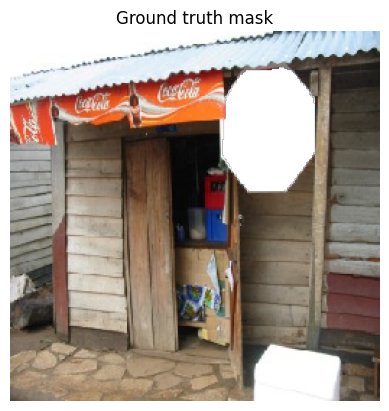

In [154]:
# Randomly show display an applied groud-truth mask from loaded dataset

random_image_idx = random.randint(0, len(prompting_dataset['X_train']))
images_from_dataset = prompting_dataset['X_train'][random_image_idx]

example_image = images_from_dataset['image']
example_mask = images_from_dataset['label']

fig, axes = plt.subplots()

print("example_image.shape", example_image.shape)

axes.imshow(example_image)
ground_truth_seg = example_mask
show_mask(ground_truth_seg, axes, True)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [155]:
def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    
    if y_indices.size == 0 or x_indices.size == 0:
        # No valid bounding box because no pixels exceed the threshold
        # Return a default or empty bounding box that your model can handle
        return [0, 0, 0, 0]
    
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [156]:
class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = item["label"]
    # print("before SAMDataset ground_truth_mask shape: ", ground_truth_mask.shape)

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add channel to the ground truth segmentation for computing loss
    inputs["ground_truth_mask"] = np.expand_dims(ground_truth_mask, axis=0)

    # print("after SAMDataset ground_truth_mask shape: ", inputs["ground_truth_mask"].shape)

    return inputs

In [157]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [158]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (1, 256, 256)


## Create PyTorch DataLoader

Next we define a PyTorch Dataloader, which allows us to get batches from the dataset.



In [159]:
# It can ONLY work with batch size of 1 for now
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)

In [160]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])
ground_truth_mask torch.Size([1, 1, 256, 256])


In [161]:
batch["ground_truth_mask"].shape

torch.Size([1, 1, 256, 256])

## Load the model

In [162]:
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

## Train the model

In [163]:
def save_checkpoint(state, filename="customSAM.pth.tar"):
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer, scheduler=None):
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    if scheduler and 'scheduler' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler'])

    return checkpoint['epoch']


device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

using cuda


100%|██████████| 1200/1200 [00:50<00:00, 23.67it/s]


EPOCH: 0
Mean loss: 752.2697385239601


100%|██████████| 1200/1200 [00:49<00:00, 24.17it/s]


EPOCH: 1
Mean loss: 415.30797377824786


100%|██████████| 1200/1200 [00:50<00:00, 23.85it/s]


EPOCH: 2
Mean loss: 376.5464407022794


 33%|███▎      | 397/1200 [00:16<00:32, 24.46it/s]

at image: 4000predicted_masks.shape torch.Size([1, 256, 256])
at image: 4000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


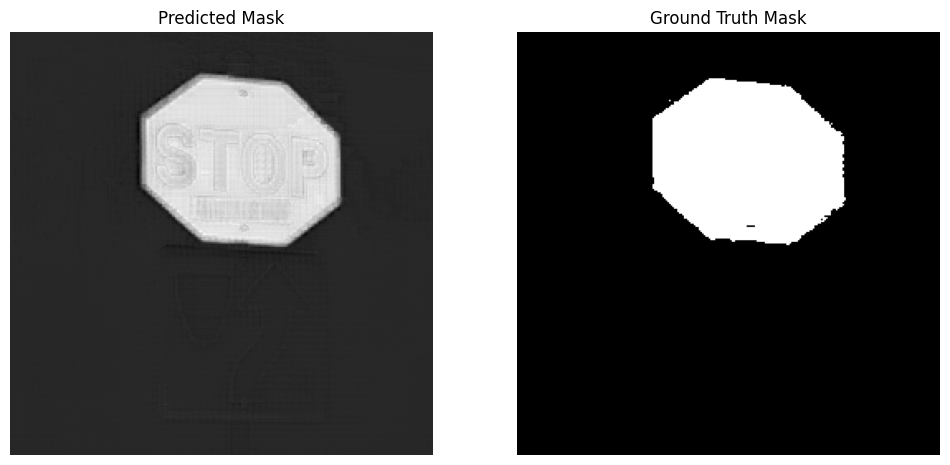

 33%|███▎      | 400/1200 [00:17<00:45, 17.57it/s]

For image 4000, loss is 379.49969482421875


100%|██████████| 1200/1200 [00:49<00:00, 24.19it/s]


EPOCH: 3
Mean loss: 342.1284086207549


100%|██████████| 1200/1200 [00:49<00:00, 24.13it/s]


EPOCH: 4
Mean loss: 323.90246167381605


100%|██████████| 1200/1200 [00:49<00:00, 24.13it/s]


EPOCH: 5
Mean loss: 326.21119736234346


 67%|██████▋   | 799/1200 [00:33<00:16, 24.43it/s]

at image: 8000predicted_masks.shape torch.Size([1, 256, 256])
at image: 8000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


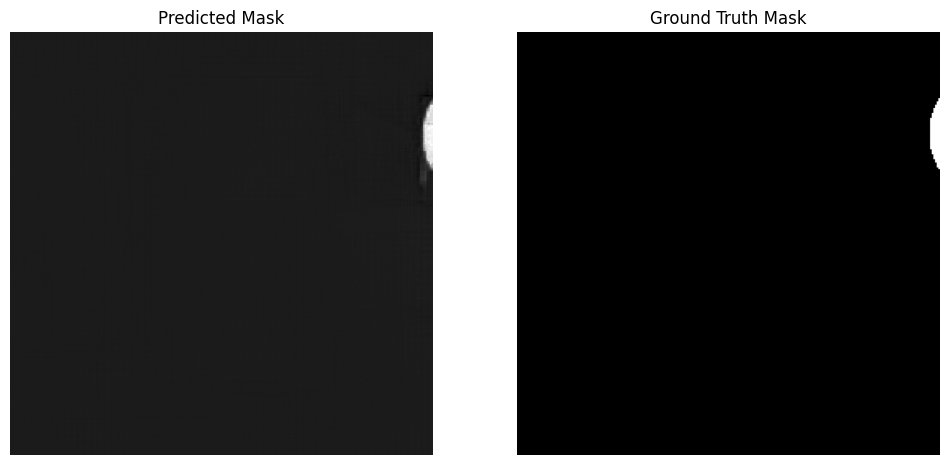

For image 8000, loss is 17.127573013305664


100%|██████████| 1200/1200 [00:50<00:00, 23.92it/s]


EPOCH: 6
Mean loss: 307.1529865276814


100%|██████████| 1200/1200 [00:49<00:00, 24.09it/s]


EPOCH: 7
Mean loss: 292.171569762826


100%|██████████| 1200/1200 [00:50<00:00, 23.99it/s]


EPOCH: 8
Mean loss: 286.5030865377188


100%|█████████▉| 1198/1200 [00:49<00:00, 24.87it/s]

at image: 12000predicted_masks.shape torch.Size([1, 256, 256])
at image: 12000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


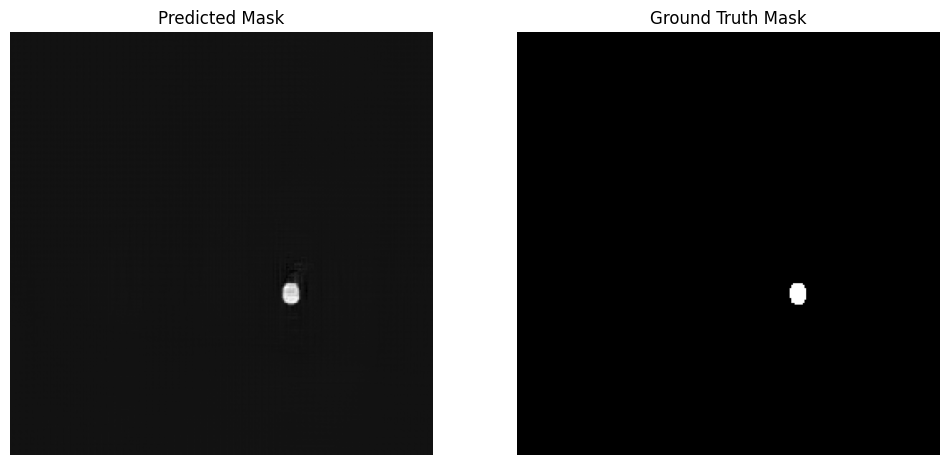

For image 12000, loss is 8.57644271850586


100%|██████████| 1200/1200 [00:50<00:00, 23.99it/s]


EPOCH: 9
Mean loss: 287.5704234860341


100%|██████████| 1200/1200 [00:50<00:00, 24.00it/s]


EPOCH: 10
Mean loss: 280.33532174189884


100%|██████████| 1200/1200 [00:49<00:00, 24.05it/s]


EPOCH: 11
Mean loss: 276.04136807084086


100%|██████████| 1200/1200 [00:49<00:00, 24.36it/s]


EPOCH: 12
Mean loss: 262.85229329427085


 33%|███▎      | 399/1200 [00:17<00:32, 24.44it/s]

at image: 16000predicted_masks.shape torch.Size([1, 256, 256])
at image: 16000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


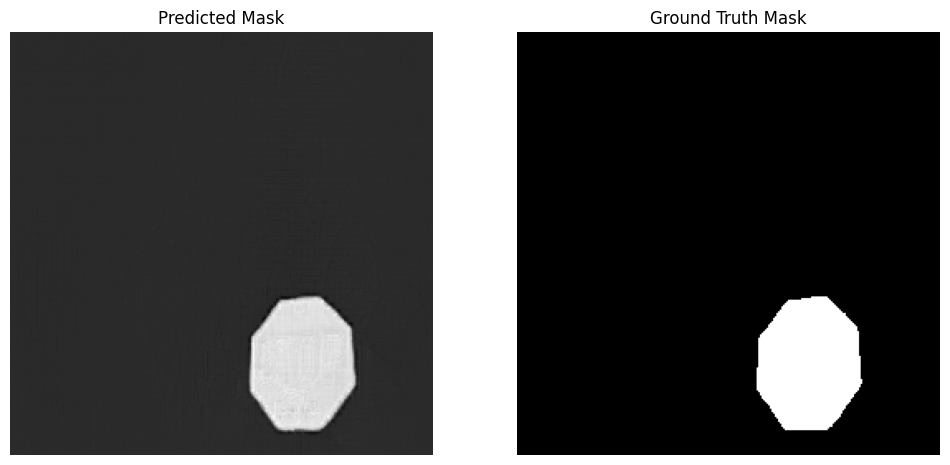

For image 16000, loss is 141.20883178710938


100%|██████████| 1200/1200 [00:50<00:00, 23.98it/s]


EPOCH: 13
Mean loss: 262.9954191770156


100%|██████████| 1200/1200 [00:49<00:00, 24.01it/s]


EPOCH: 14
Mean loss: 270.69272341907026


100%|██████████| 1200/1200 [00:49<00:00, 24.16it/s]


EPOCH: 15
Mean loss: 264.36629199127356


 67%|██████▋   | 799/1200 [00:33<00:16, 24.57it/s]

at image: 20000predicted_masks.shape torch.Size([1, 256, 256])
at image: 20000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


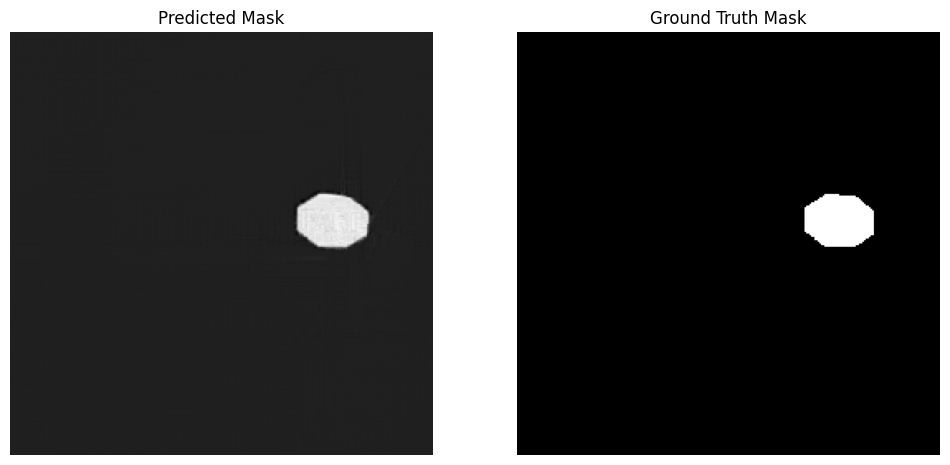

For image 20000, loss is 25.324398040771484


100%|██████████| 1200/1200 [00:49<00:00, 24.04it/s]


EPOCH: 16
Mean loss: 247.13588390111923


100%|██████████| 1200/1200 [00:49<00:00, 24.10it/s]


EPOCH: 17
Mean loss: 241.41367796182632


100%|██████████| 1200/1200 [00:49<00:00, 24.22it/s]


EPOCH: 18
Mean loss: 245.31220452964305


100%|█████████▉| 1198/1200 [00:49<00:00, 25.32it/s]

at image: 24000predicted_masks.shape torch.Size([1, 256, 256])
at image: 24000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


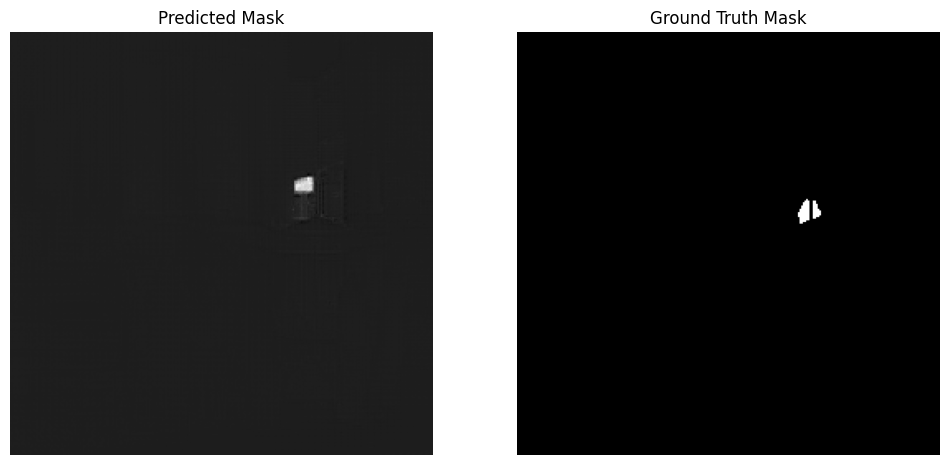

For image 24000, loss is 153.2779998779297


100%|██████████| 1200/1200 [00:49<00:00, 24.18it/s]


EPOCH: 19
Mean loss: 231.80983816345534


100%|██████████| 1200/1200 [00:49<00:00, 24.20it/s]


EPOCH: 20
Mean loss: 267.0931803538402


100%|██████████| 1200/1200 [00:49<00:00, 24.32it/s]


EPOCH: 21
Mean loss: 255.36522829075653


100%|██████████| 1200/1200 [00:49<00:00, 24.33it/s]


EPOCH: 22
Mean loss: 255.47357099692027


 33%|███▎      | 398/1200 [00:16<00:31, 25.50it/s]

at image: 28000predicted_masks.shape torch.Size([1, 256, 256])
at image: 28000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


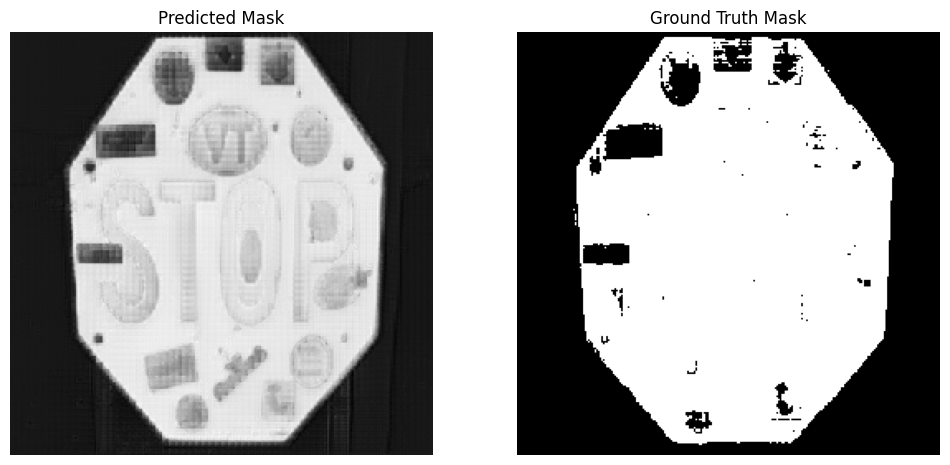

For image 28000, loss is 1348.703857421875


100%|██████████| 1200/1200 [00:49<00:00, 24.29it/s]


EPOCH: 23
Mean loss: 250.86461049159368


100%|██████████| 1200/1200 [00:49<00:00, 24.19it/s]


EPOCH: 24
Mean loss: 250.61427250325679


100%|██████████| 1200/1200 [00:49<00:00, 24.27it/s]


EPOCH: 25
Mean loss: 223.66659649074077


 67%|██████▋   | 799/1200 [00:32<00:16, 24.46it/s]

at image: 32000predicted_masks.shape torch.Size([1, 256, 256])
at image: 32000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


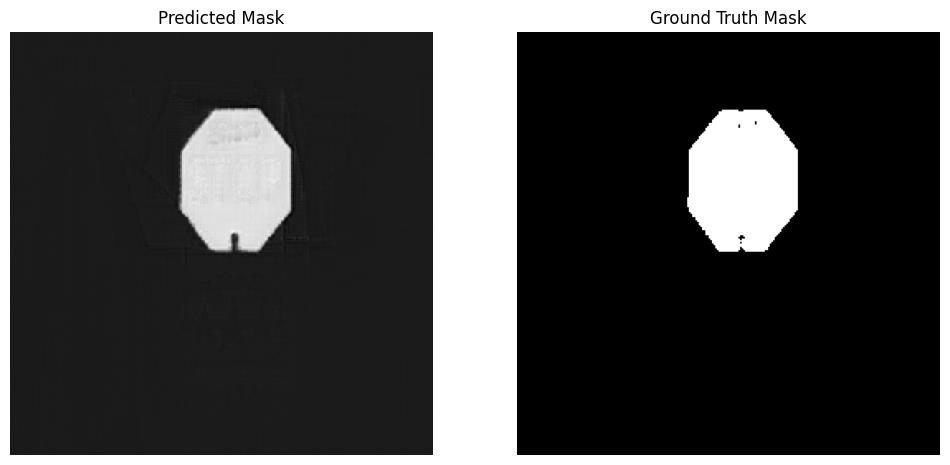

For image 32000, loss is 80.34551239013672


100%|██████████| 1200/1200 [00:49<00:00, 24.27it/s]


EPOCH: 26
Mean loss: 237.55855387369792


100%|██████████| 1200/1200 [00:49<00:00, 24.06it/s]


EPOCH: 27
Mean loss: 225.54378633250792


100%|██████████| 1200/1200 [00:50<00:00, 23.82it/s]


EPOCH: 28
Mean loss: 230.53720798770587


100%|█████████▉| 1198/1200 [00:49<00:00, 24.69it/s]

at image: 36000predicted_masks.shape torch.Size([1, 256, 256])
at image: 36000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


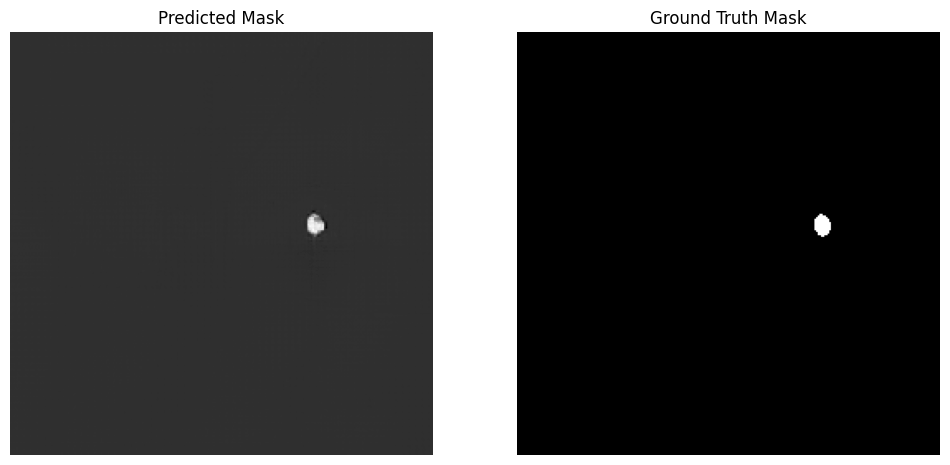

100%|██████████| 1200/1200 [00:50<00:00, 23.95it/s]

For image 36000, loss is 17.118484497070312


EPOCH: 29
Mean loss: 229.74606567939122


100%|██████████| 1200/1200 [00:50<00:00, 23.89it/s]


EPOCH: 30
Mean loss: 240.429027608037


100%|██████████| 1200/1200 [00:49<00:00, 24.22it/s]


EPOCH: 31
Mean loss: 248.09468593557676


100%|██████████| 1200/1200 [00:49<00:00, 24.05it/s]


EPOCH: 32
Mean loss: 236.99858576377233


 33%|███▎      | 397/1200 [00:16<00:31, 25.48it/s]

at image: 40000predicted_masks.shape torch.Size([1, 256, 256])
at image: 40000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


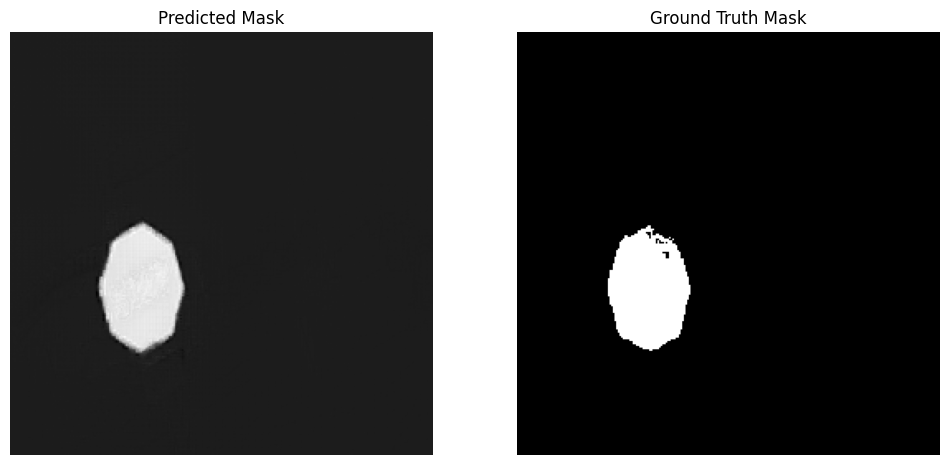

 33%|███▎      | 400/1200 [00:17<00:42, 18.72it/s]

For image 40000, loss is 146.84197998046875


100%|██████████| 1200/1200 [00:49<00:00, 24.36it/s]


EPOCH: 33
Mean loss: 236.49449875930944


100%|██████████| 1200/1200 [00:50<00:00, 23.80it/s]


EPOCH: 34
Mean loss: 229.70575150092444


100%|██████████| 1200/1200 [00:49<00:00, 24.44it/s]


EPOCH: 35
Mean loss: 222.25517527619996


 67%|██████▋   | 799/1200 [00:33<00:16, 24.33it/s]

at image: 44000predicted_masks.shape torch.Size([1, 256, 256])
at image: 44000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


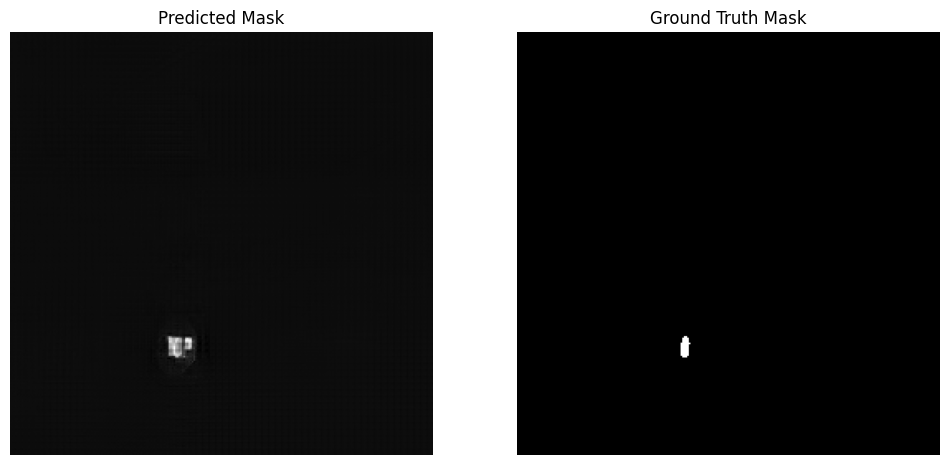

For image 44000, loss is 37.66481018066406


100%|██████████| 1200/1200 [00:50<00:00, 23.86it/s]


EPOCH: 36
Mean loss: 221.33627306381862


100%|██████████| 1200/1200 [00:49<00:00, 24.20it/s]


EPOCH: 37
Mean loss: 244.1031485247612


100%|██████████| 1200/1200 [00:49<00:00, 24.19it/s]


EPOCH: 38
Mean loss: 217.74449544648328


100%|█████████▉| 1199/1200 [00:49<00:00, 24.81it/s]

at image: 48000predicted_masks.shape torch.Size([1, 256, 256])
at image: 48000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


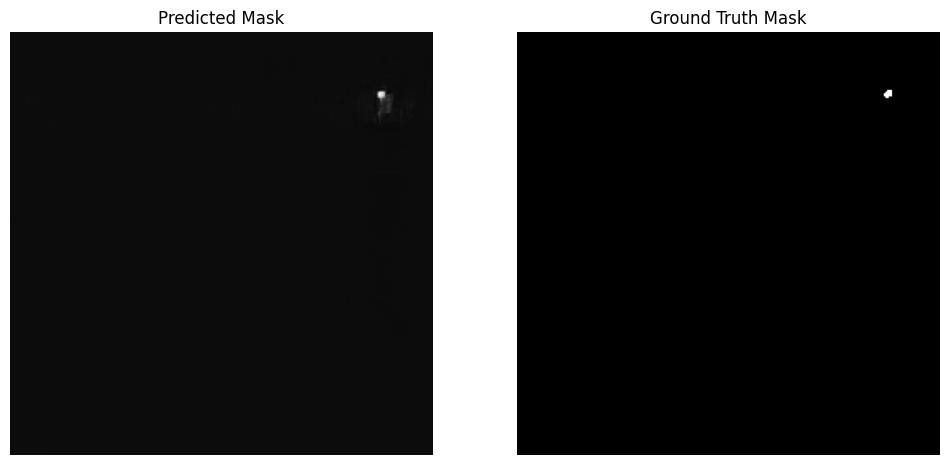

For image 48000, loss is 8.049501419067383


100%|██████████| 1200/1200 [00:50<00:00, 23.91it/s]


EPOCH: 39
Mean loss: 220.21213418463867


100%|██████████| 1200/1200 [00:48<00:00, 24.88it/s]


EPOCH: 40
Mean loss: 237.6151486465335


100%|██████████| 1200/1200 [00:49<00:00, 24.31it/s]


EPOCH: 41
Mean loss: 219.82573729256788


100%|██████████| 1200/1200 [00:50<00:00, 23.93it/s]


EPOCH: 42
Mean loss: 202.60775761306286


 33%|███▎      | 397/1200 [00:16<00:32, 24.41it/s]

at image: 52000predicted_masks.shape torch.Size([1, 256, 256])
at image: 52000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


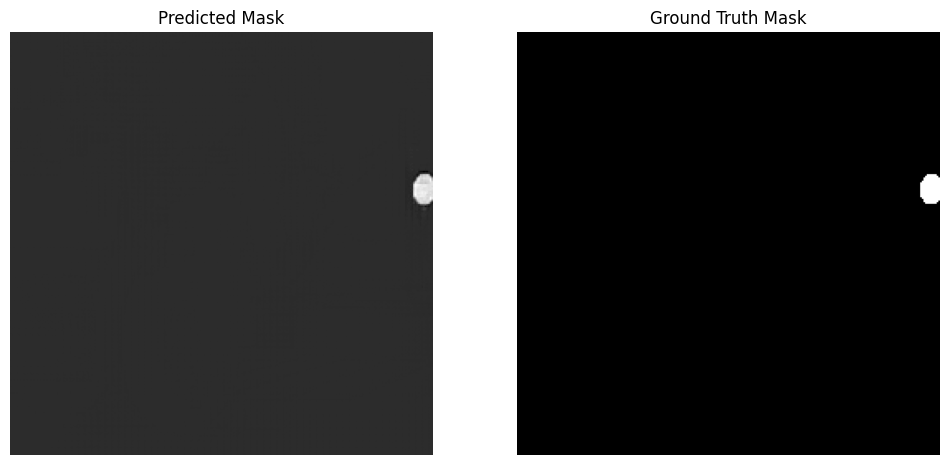

 33%|███▎      | 400/1200 [00:17<00:44, 18.12it/s]

For image 52000, loss is 3.59521746635437


100%|██████████| 1200/1200 [00:50<00:00, 24.00it/s]


EPOCH: 43
Mean loss: 215.6991709047556


100%|██████████| 1200/1200 [00:50<00:00, 23.99it/s]


EPOCH: 44
Mean loss: 212.5040350218614


100%|██████████| 1200/1200 [00:49<00:00, 24.24it/s]


EPOCH: 45
Mean loss: 212.61240505894025


 67%|██████▋   | 799/1200 [00:33<00:16, 24.16it/s]

at image: 56000predicted_masks.shape torch.Size([1, 256, 256])
at image: 56000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


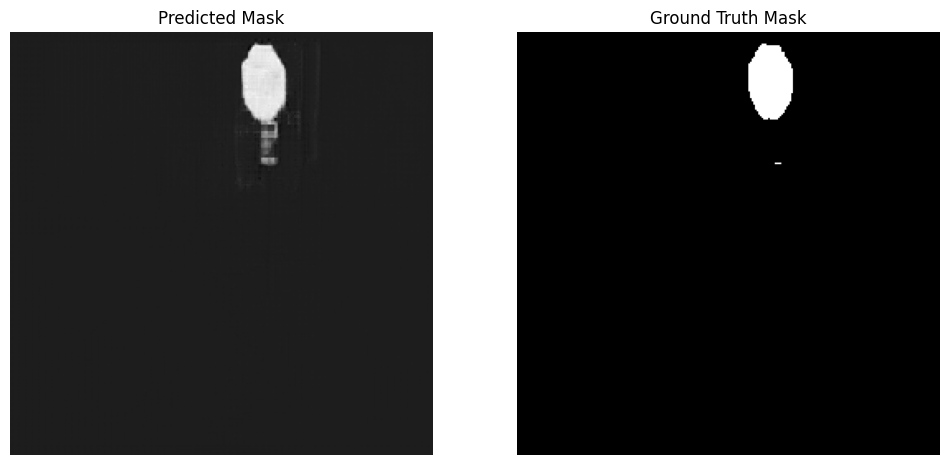

 67%|██████▋   | 802/1200 [00:34<00:28, 13.90it/s]

For image 56000, loss is 76.8165512084961


100%|██████████| 1200/1200 [00:50<00:00, 23.88it/s]


EPOCH: 46
Mean loss: 206.3461314012607


100%|██████████| 1200/1200 [00:49<00:00, 24.08it/s]


EPOCH: 47
Mean loss: 216.77884991884233


100%|██████████| 1200/1200 [00:49<00:00, 24.08it/s]


EPOCH: 48
Mean loss: 219.2607054847479


100%|█████████▉| 1197/1200 [00:49<00:00, 24.42it/s]

at image: 60000predicted_masks.shape torch.Size([1, 256, 256])
at image: 60000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


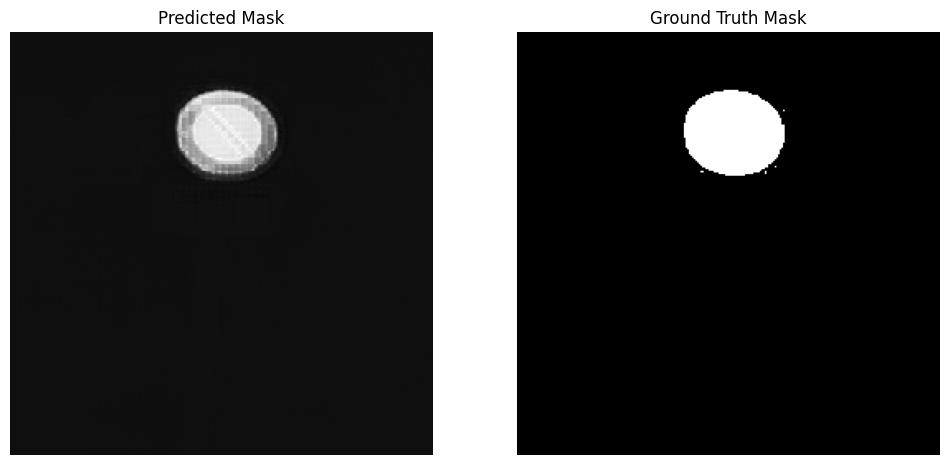

100%|██████████| 1200/1200 [00:50<00:00, 17.82it/s]

For image 60000, loss is 261.39788818359375


100%|██████████| 1200/1200 [00:50<00:00, 23.86it/s]


EPOCH: 49
Mean loss: 215.0826303056876


100%|██████████| 1200/1200 [00:49<00:00, 24.01it/s]


EPOCH: 50
Mean loss: 202.9371671640873


100%|██████████| 1200/1200 [00:50<00:00, 23.82it/s]


EPOCH: 51
Mean loss: 206.57736702700456


100%|██████████| 1200/1200 [00:50<00:00, 23.96it/s]


EPOCH: 52
Mean loss: 226.91241002976895


 33%|███▎      | 397/1200 [00:17<00:33, 23.62it/s]

at image: 64000predicted_masks.shape torch.Size([1, 256, 256])
at image: 64000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


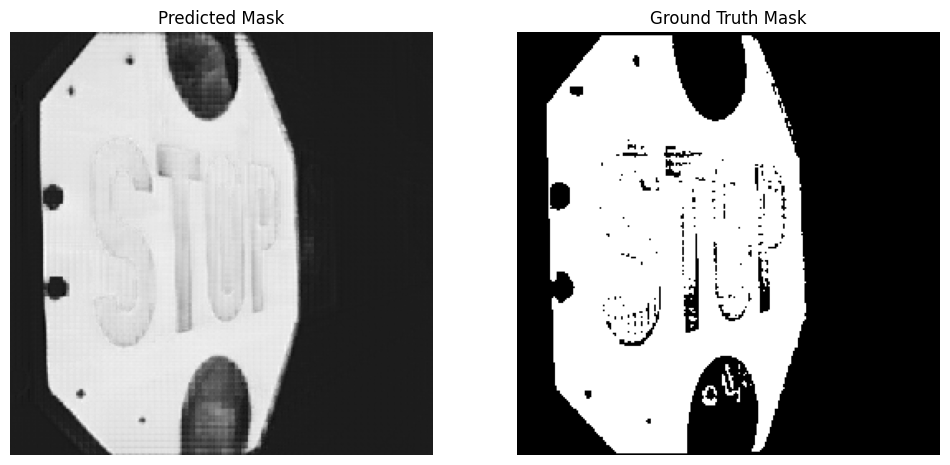

 33%|███▎      | 400/1200 [00:17<00:47, 16.84it/s]

For image 64000, loss is 1646.651123046875


100%|██████████| 1200/1200 [00:50<00:00, 23.78it/s]


EPOCH: 53
Mean loss: 217.21817133347193


100%|██████████| 1200/1200 [00:50<00:00, 23.98it/s]


EPOCH: 54
Mean loss: 197.90471577823163


100%|██████████| 1200/1200 [00:49<00:00, 24.20it/s]


EPOCH: 55
Mean loss: 226.81889804104964


 66%|██████▋   | 798/1200 [00:33<00:16, 24.41it/s]

at image: 68000predicted_masks.shape torch.Size([1, 256, 256])
at image: 68000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


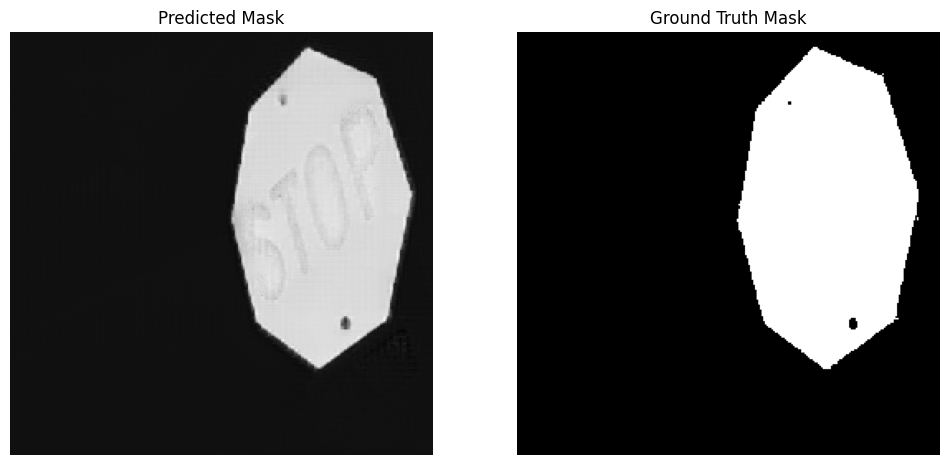

For image 68000, loss is 147.08786010742188


100%|██████████| 1200/1200 [00:50<00:00, 24.00it/s]


EPOCH: 56
Mean loss: 204.5164554842313


100%|██████████| 1200/1200 [00:50<00:00, 23.86it/s]


EPOCH: 57
Mean loss: 199.26690650542577


100%|██████████| 1200/1200 [00:50<00:00, 23.80it/s]


EPOCH: 58
Mean loss: 207.19950932880243


100%|█████████▉| 1197/1200 [00:49<00:00, 25.00it/s]

at image: 72000predicted_masks.shape torch.Size([1, 256, 256])
at image: 72000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


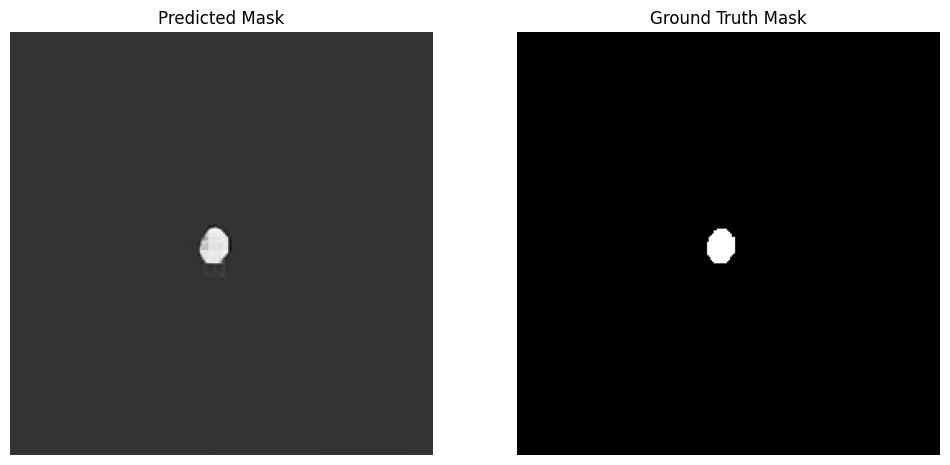

100%|██████████| 1200/1200 [00:49<00:00, 24.08it/s]

For image 72000, loss is 12.460500717163086


EPOCH: 59
Mean loss: 204.87942501773438


100%|██████████| 1200/1200 [00:50<00:00, 23.80it/s]


EPOCH: 60
Mean loss: 208.55473596453666


100%|██████████| 1200/1200 [00:49<00:00, 24.05it/s]


EPOCH: 61
Mean loss: 206.7719166769584


100%|██████████| 1200/1200 [00:50<00:00, 23.92it/s]


EPOCH: 62
Mean loss: 201.0546157725652


 33%|███▎      | 399/1200 [00:17<00:33, 24.16it/s]

at image: 76000predicted_masks.shape torch.Size([1, 256, 256])
at image: 76000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


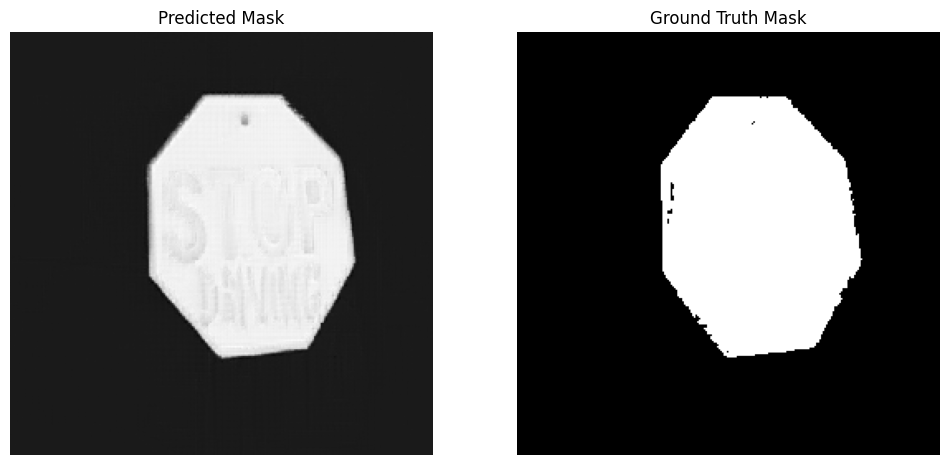

For image 76000, loss is 506.35003662109375


100%|██████████| 1200/1200 [00:50<00:00, 23.97it/s]


EPOCH: 63
Mean loss: 195.9397520924608


100%|██████████| 1200/1200 [00:51<00:00, 23.48it/s]


EPOCH: 64
Mean loss: 198.04243729660908


100%|██████████| 1200/1200 [00:50<00:00, 23.77it/s]


EPOCH: 65
Mean loss: 196.16781758705775


 66%|██████▋   | 798/1200 [00:33<00:16, 24.42it/s]

at image: 80000predicted_masks.shape torch.Size([1, 256, 256])
at image: 80000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


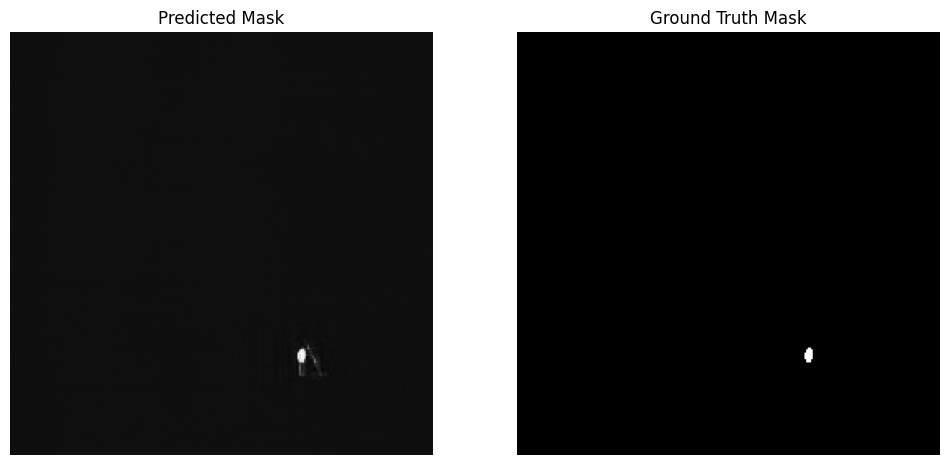

 67%|██████▋   | 801/1200 [00:33<00:21, 18.16it/s]

For image 80000, loss is 5.725205898284912


100%|██████████| 1200/1200 [00:50<00:00, 23.83it/s]


EPOCH: 66
Mean loss: 202.15974197765192


100%|██████████| 1200/1200 [00:49<00:00, 24.05it/s]


EPOCH: 67
Mean loss: 190.34889714330436


100%|██████████| 1200/1200 [00:50<00:00, 23.88it/s]


EPOCH: 68
Mean loss: 205.62820690294106


100%|█████████▉| 1197/1200 [00:49<00:00, 24.57it/s]

at image: 84000predicted_masks.shape torch.Size([1, 256, 256])
at image: 84000ground_truth_mask.shape torch.Size([1, 1, 256, 256])


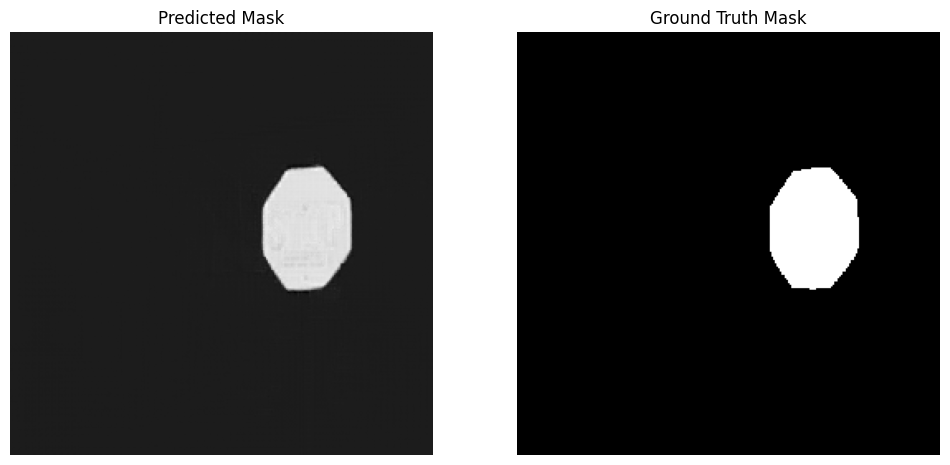

100%|██████████| 1200/1200 [00:49<00:00, 18.21it/s]

For image 84000, loss is 46.86499786376953


100%|██████████| 1200/1200 [00:49<00:00, 24.02it/s]


EPOCH: 69
Mean loss: 197.4793561009566
None


In [14]:
CONTINUE_TRAINING = False
num_epochs = 70
SHOW_EXAMPLE_PLOTS = True
plot_count = 0
MSE = []

print("using " + device)
model.to(device)

model.train()

if CONTINUE_TRAINING:
    checkpoint = torch.load("customSAM_training_checkpoint.pth.tar")
    start_epoch = load_checkpoint(checkpoint, model, optimizer)
    training_range = range(start_epoch, num_epochs)
else:
    training_range = range(num_epochs)

for epoch in training_range:
    epoch_losses = []

    checkpoint = {
        'epoch': epoch + 1,  # So next time it will continue from the next epoch
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }

    for batch in tqdm(train_dataloader):
      plot_count += 1
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)
      
      # compute loss
      predicted_masks = outputs.pred_masks
   
      # Add paddings to the ground_truth_masks
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      
      if SHOW_EXAMPLE_PLOTS and plot_count % 4000 == 0:
        print("at image: " + str(plot_count) + "predicted_masks.shape", predicted_masks[0][0].shape)
        print("at image: " + str(plot_count) + "ground_truth_mask.shape", ground_truth_masks.shape)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots
        axes[0].imshow(predicted_masks[0][0].detach().cpu().squeeze().numpy(), cmap='gray')
        axes[0].set_title('Predicted Mask')
        axes[0].axis('off')

        axes[1].imshow(ground_truth_masks[0].detach().cpu().squeeze().numpy() , cmap='gray')
        axes[1].set_title('Ground Truth Mask')
        axes[1].axis('off')
        plt.show()


      # loss = ce_loss(predicted_masks, ground_truth_masks.unsqueeze(0))
      loss_fn = MSELoss()
      loss = loss_fn(predicted_masks, ground_truth_masks.unsqueeze(0))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      current_loss = loss.item()

      # optimize
      optimizer.step()
      epoch_losses.append(current_loss)


      if plot_count % 4000 == 0:
        print("For image " + str(plot_count) + ", loss is " + str(loss.item()))

    save_checkpoint(checkpoint, filename="customSAM_training_checkpoint.pth.tar")

    MSE.append(mean(epoch_losses))
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    


## Inference

Important note here: as we used the Dice loss with `sigmoid=True`, we need to make sure to appropriately apply a sigmoid activation function to the predicted masks. Hence we won't use the processor's `post_process_masks` method here.

In [164]:
# epochs = list(range(71))  # Epochs from 0 to 70
# # Creating the plot
# plt.figure(figsize=(10, 6))
# plt.plot(epochs, MSE, marker='o', linestyle='-', color='blue')
# plt.title('Mean Squared Error (MSE) Across Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('MSE')
# plt.grid(True)
# plt.show()

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [165]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = random.randint(0, 1200)

# load image
image = dataset[idx]["image"]
# print(image)

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

IndexError: list index out of range

974
pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])
Loading Model


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model Loaded


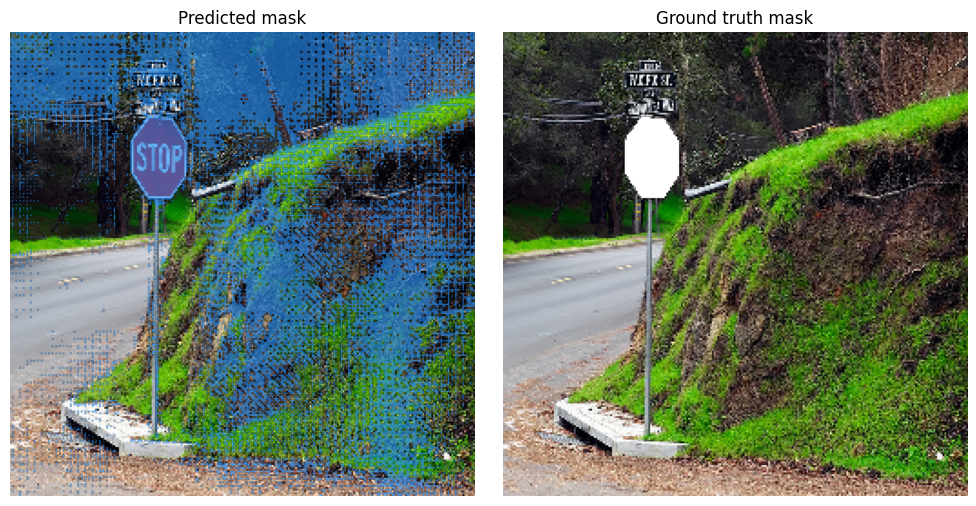

In [168]:
import numpy as np
from PIL import Image

# let's take a random training example
# idx = random.randint(0, 1600)
idx = 974
print(idx)
# print(len(dataset))

# load image
image = dataset[idx]["image"]
# print(image)

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)


print("Loading Model")

# checkpoint = torch.load("customSAM_training_checkpoint.pth.tar")
checkpoint = torch.load("customSAM_general.pth.tar")
# checkpoint = torch.load("customSAM_stop_sign.pth.tar")
load_checkpoint(checkpoint, model, optimizer)
print("Model Loaded")
model.eval()
model.to(device)

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns, and optional figure size

# Plot for the predicted mask
axes[0].imshow(image, cmap='gray')
show_mask(medsam_seg, axes[0])
axes[0].set_title("Predicted mask")
axes[0].axis("off")

# Plot for the ground truth mask
axes[1].imshow(image, cmap='gray')
show_mask(ground_truth_mask, axes[1])
axes[1].set_title("Ground truth mask")
axes[1].axis("off")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Legacy

The code below was used during the creation of this notebook, but was eventually not used anymore.

In [ ]:
# Legacy FULL DATA LOADER! THIS DATA LOADER WILL LOAD EVERYTHING!

# prompting_dataset = {}

# for cls in CLASS_LIST:
#     image_url = os.path.join(BASE_URL_TO_DATASET, cls)
#     samples = np.load(image_url + '/samples.npy', allow_pickle=True)
    
#     dataset = []

#     mask_base_url = os.path.join(BASE_URL_TO_MASK, cls)
#     student_dirs = [os.path.join(mask_base_url, d) for d in os.listdir(mask_base_url) if os.path.isdir(os.path.join(mask_base_url, d))]

#     for student_dir in student_dirs:
#         print("For " + cls + ", loading from " + student_dir)

#         for i in range(len(samples)):
#             current_image = samples[i]
#             mask_url = os.path.join(student_dir, 'masks', f"{i}_0_mask.png")

#             # read the first mask for each image 
#             # (there could be varying number of masks for a single image somehow)
#             current_mask = cv2.imread(mask_url, cv2.IMREAD_GRAYSCALE)

#             if current_mask is None:
#                 print(f"Failed to load mask image with path: {mask_url}")
#                 continue

#             print(f"loading: {mask_url}")

#             current_image_resized = cv2.resize(current_image, STANDARD_SIZE, interpolation=cv2.INTER_NEAREST)
#             current_mask_resized = cv2.resize(current_mask, STANDARD_SIZE, interpolation=cv2.INTER_NEAREST)

#             # Ensure the image is in the correct data type
#             # otherwise, cannot load 'bus' and 'Chalk group'
#             if current_image_resized.dtype != np.uint8:
#                 current_image_resized = current_image_resized.astype(np.uint8)

#             # Convert greyscale images to rgb images by repeating channels
#             # otherwise, cannot load 'cat' and 'clock'
#             if len(current_image_resized.shape) == 2 or current_image_resized.shape[2] == 1:
#                 current_image_resized = cv2.cvtColor(current_image_resized, cv2.COLOR_GRAY2RGB)

#             # print("current_image_resized", current_image_resized.shape)
#             # print("current_mask_resized", current_mask_resized.shape)

#             dataset.append({"image": current_image_resized, "label": current_mask_resized})

#     n_train = math.ceil(len(dataset) * 0.75)
#     X_train, X_test = train_test_split(dataset, train_size=n_train, test_size=len(dataset) - n_train, random_state=4803)

#     print("len(X_train)", len(X_train))
#     print("len(X_test)", len(X_test))

#     prompting_dataset[cls] = {
#         "X_train": X_train,
#         "X_test": X_test
#     }

#     # # Create a figure with two subplots
#     # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # figsize can be adjusted as needed

#     # ax1.imshow(X_train[650], cmap='gray')
#     # ax1.set_title('Image ' + str(i) + ' For ' + cls)
#     # ax1.axis('off')  
#     # ax2.imshow(y_train[650], cmap='gray')
#     # ax2.set_title('Mask ' + str(i) + ' For ' + cls)
#     # ax2.axis('off')

#     # plt.show()


# # a sample output of prompting_dataset: 
# # {
# #     'Cat': {
# #         "X_train": X_train,
# #         "X_test": X_test,
# #     },

# #     "Dog": {
# #         "X_train": X_train,
# #         "X_test": X_test,
# #     }
# # }

# for cls in CLASS_LIST:
#     print(cls + ': ' + str(len(prompting_dataset[cls]['X_train'])))

In [ ]:
# STOP SIGN MSE
mse = [752.2697385239601, 415.30797377824786, 376.5464407022794, 342.1284086207549, 323.90246167381605, 
       326.21119736234346, 307.1529865276814, 292.171569762826, 286.5030865377188, 287.5704234860341, 
       280.33532174189884, 276.04136807084086, 262.85229329427085, 262.9954191770156, 270.69272341907026, 
       264.36629199127356, 247.13588390111923, 241.41367796182632, 245.31220452964305, 231.80983816345534, 
       267.0931803538402, 255.36522829075653, 255.47357099692027, 250.86461049159368, 250.61427250325679, 
       223.66659649074077, 237.55855387369792, 225.54378633250792, 230.53720798770587, 229.74606567939122, 
       240.429027608037, 248.09468593557676, 236.99858576377233, 236.49449875930944, 229.70575150092444, 
       222.25517527619996, 221.33627306381862, 244.1031485247612, 217.74449544648328, 220.21213418463867, 
       237.6151486465335, 219.82573729256788, 202.60775761306286, 215.6991709047556, 212.5040350218614, 
       212.61240505894025, 206.3461314012607, 216.77884991884233, 219.2607054847479, 215.0826303056876, 
       202.9371671640873, 206.57736702700456, 226.91241002976895, 217.21817133347193, 197.90471577823163, 
       226.81889804104964, 204.5164554842313, 199.26690650542577, 207.19950932880243, 204.87942501773438, 
       208.55473596453666, 206.7719166769584, 201.0546157725652, 195.9397520924608, 198.04243729660908, 
       196.16781758705775, 202.15974197765192, 190.34889714330436, 205.62820690294106, 197.4793561009566, 
       197.4793561009566]